<a href="https://colab.research.google.com/github/chihoko12/plant_disease/blob/main/plant_disease_cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 2.1 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 44.7 MB/s 
     |████████████████████████████████| 186 kB 49.5 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 51 kB 314 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

# Gathering Data

In [3]:
urls = search_images_ddg('apple plant disease', max_images=100)
len(urls), urls[0]

(100,
 'https://extension.umaine.edu/fruit/wp-content/uploads/sites/8/2011/02/scab-on-fruit-2.jpg')

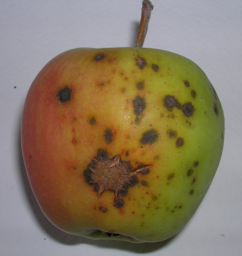

In [4]:
download_url(urls[0],'images/apple_disease.jpg')
im = Image.open('images/apple_disease.jpg')
im.thumbnail((256,256))
im

In [5]:
!pip install jmd_imagescraper

In [6]:
from jmd_imagescraper.core import *
from pathlib import Path

In [110]:
# the path where the picture is downloaded
path = '/images'

In [111]:
apple_disease_types = 'healthy','multiple_diseases','rust','scab'
path = Path(path)

In [112]:
# create 4 folders and downloads 200 pictures into each of them
if not path.exists():
  path.mkdir()
  for o in apple_disease_types:
    dest = (path/o)
    duckduckgo_search(path,f'{o}',f'{o} apple leave', max_results=200)

In [113]:
fns = get_image_files(path)
fns

(#795) [Path('/images/rust/158_792b92b6.jpg'),Path('/images/rust/189_7b3f7cf1.jpg'),Path('/images/rust/167_e4961d3d.jpg'),Path('/images/rust/116_1596242b.jpg'),Path('/images/rust/066_9f7b24d6.jpg'),Path('/images/rust/181_e5a4da1e.jpg'),Path('/images/rust/078_9c849735.jpg'),Path('/images/rust/005_fe264ec9.jpg'),Path('/images/rust/017_35dec4ad.jpg'),Path('/images/rust/152_16e1cff0.jpg')...]

In [114]:
failed = verify_images(fns)
failed

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3310d2c440>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3310d2c440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

(#0) []

In [115]:
failed.map(Path.unlink)

(#0) []

# From Data to DataLoaders

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
class DataLoaders(GetAttr):
  def __int__(self, *loaders): self.loaders = loaders
  def __getitem(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [118]:
apples = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [119]:
dls = apples.dataloaders(path)

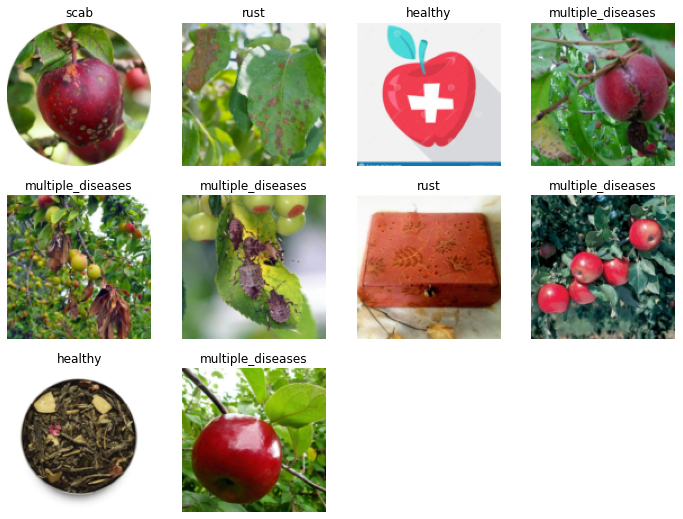

In [120]:
dls.valid.show_batch(max_n=10, nrows=3)

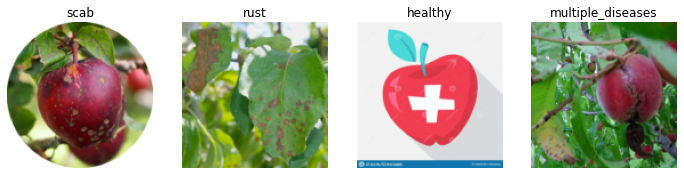

In [121]:
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

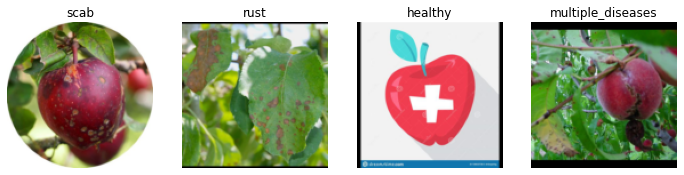

In [122]:
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

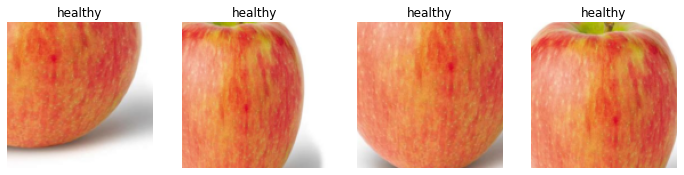

In [123]:
apples = apples.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augumentation

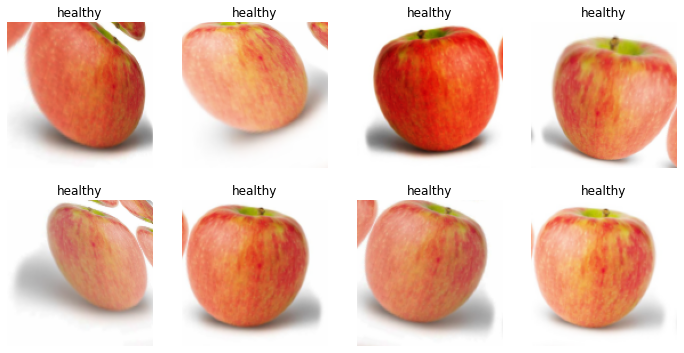

In [124]:
apples = apples.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training the Model and Using it to Clean the Data

In [125]:
apples = apples.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = apples.dataloaders(path)

In [126]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.190640,1.438200,0.503145,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.557052,1.213008,0.459119,00:09
1,1.393769,1.205743,0.452830,00:09
2,1.262686,1.174019,0.452830,00:09
3,1.140337,1.172889,0.452830,00:09


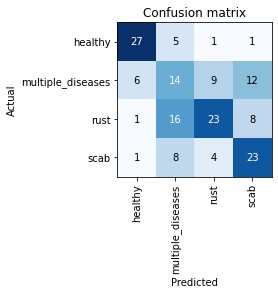

In [127]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

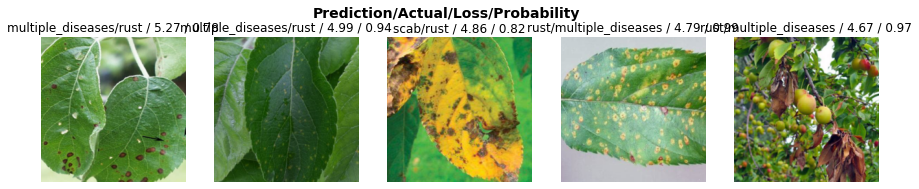

In [128]:
interp.plot_top_losses(5,nrows=1)

In [129]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [147]:
# to delete (unlink) all images selected for deletion
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# to move images for which I've selected a different category
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Using the Model for Inference

In [131]:
learn.export()

In [132]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [133]:
learn_inf = load_learner(path/'export.pkl')

In [134]:
learn_inf.predict('images/apple_disease.jpg')

('scab', tensor(3), tensor([0.0033, 0.1857, 0.0019, 0.8091]))

In [135]:
learn_inf.dls.vocab

['healthy', 'multiple_diseases', 'rust', 'scab']

# Creating a Notebook App from the Model

In [136]:
# file upload widget
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [137]:
btn_upload = SimpleNamespace(data=['images/apple_disease.jpg'])

In [138]:
img = PILImage.create(btn_upload.data[-1])

In [139]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [140]:
pred,pred_idx,probs = learn_inf.predict(img)

In [141]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: scab; Probability: 0.8091')

In [142]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [143]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.cleaner_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [144]:
btn_upload = widgets.FileUpload()

In [145]:
VBox = ([widgets.Label('Select your apple leave!'),
         btn_upload, btn_run, out_pl, lbl_pred])

# Turning the Notebook into a App

In [146]:
!pip install voila
!jupyter serverextention enable --sys-prefix voila

Traceback (most recent call last):
  File "/usr/local/bin/jupyter", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/command.py", line 230, in main
    command = _jupyter_abspath(subcommand)
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/command.py", line 133, in _jupyter_abspath
    'Jupyter command `{}` not found.'.format(jupyter_subcommand)
Exception: Jupyter command `jupyter-serverextention` not found.
